
# T001 

## Connect to ChEMBL database

In [2]:
import math
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory

import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
from chembl_webresource_client.new_client import new_client
from tqdm.auto import tqdm

In [3]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

In [4]:
# Next, we create resource objects for API access
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

In [5]:
type(targets_api)

chembl_webresource_client.query_set.QuerySet

In [6]:
# Get UniProt ID of the target of interest 
uniprot_id = "P27487"

In [7]:
# Get target information from ChEMBL but restrict it to specified values only
targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)
print(f'The type of the targets is "{type(targets)}"')

The type of the targets is "<class 'chembl_webresource_client.query_set.QuerySet'>"


In [8]:
# Download target data from ChEMBL
targets = pd.DataFrame.from_records(targets)
targets

,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,Dipeptidyl peptidase IV,CHEMBL284,SINGLE PROTEIN
1,Homo sapiens,Dipeptidyl peptidase IV,CHEMBL284,SINGLE PROTEIN
2,Homo sapiens,Dipeptidyl peptidase II and dipeptidyl peptida...,CHEMBL2111469,SELECTIVITY GROUP


In [9]:
# After checking the entries, we select the first entry as our target of interest:
# It is a single protein and represents the Dipeptidyl peptidase IV (CHEMBL284)
target = targets.iloc[0]
target

organism                       Homo sapiens
pref_name           Dipeptidyl peptidase IV
target_chembl_id                  CHEMBL284
target_type                  SINGLE PROTEIN
Name: 0, dtype: object

In [10]:
# Save selected ChEMBL ID.
chembl_id = target.target_chembl_id
print(f"The target ChEMBL ID is {chembl_id}")

The target ChEMBL ID is CHEMBL284


In [11]:
# Now, we want to query bioactivity data for the target of interest.
# Fetch bioactivity data for the target from ChEMBL¶
bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id, type="IC50", relation="=", assay_type="B"
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
)

print(f"Length and type of bioactivities object: {len(bioactivities)}, {type(bioactivities)}")

Length and type of bioactivities object: 4425, <class 'chembl_webresource_client.query_set.QuerySet'>


In [12]:
# Each entry in our bioactivity set holds the following information:
print(f"Length and type of first element: {len(bioactivities[0])}, {type(bioactivities[0])}")
bioactivities[0]

Length and type of first element: 13, <class 'dict'>


{'activity_id': 105501,
 'assay_chembl_id': 'CHEMBL666573',
 'assay_description': 'In vitro inhibition of human Dipeptidylpeptidase IV.',
 'assay_type': 'B',
 'molecule_chembl_id': 'CHEMBL93558',
 'relation': '=',
 'standard_units': 'nM',
 'standard_value': '217000.0',
 'target_chembl_id': 'CHEMBL284',
 'target_organism': 'Homo sapiens',
 'type': 'IC50',
 'units': 'uM',
 'value': '217.0'}

In [13]:
# Download bioactivity data from ChEMBL
bioactivities_df = pd.DataFrame.from_dict(bioactivities)
print(f"DataFrame shape: {bioactivities_df.shape}")
bioactivities_df.head()

DataFrame shape: (4425, 13)


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,105501,CHEMBL666573,In vitro inhibition of human Dipeptidylpeptida...,B,CHEMBL93558,=,nM,217000.0,CHEMBL284,Homo sapiens,IC50,uM,217.0
1,106644,CHEMBL666573,In vitro inhibition of human Dipeptidylpeptida...,B,CHEMBL443622,=,nM,41000.0,CHEMBL284,Homo sapiens,IC50,uM,41.0
2,106647,CHEMBL666573,In vitro inhibition of human Dipeptidylpeptida...,B,CHEMBL403882,=,nM,15000.0,CHEMBL284,Homo sapiens,IC50,uM,15.0
3,108924,CHEMBL666573,In vitro inhibition of human Dipeptidylpeptida...,B,CHEMBL328795,=,nM,188000.0,CHEMBL284,Homo sapiens,IC50,uM,188.0
4,111620,CHEMBL666573,In vitro inhibition of human Dipeptidylpeptida...,B,CHEMBL97674,=,nM,247000.0,CHEMBL284,Homo sapiens,IC50,uM,247.0


Note that the first two rows describe the same bioactivity entry; we will remove such artifacts later during the deduplication step. Note also that we have columns for standard_units/units and standard_values/values; in the following, we will use the standardized columns (standardization by ChEMBL), and thus, we drop the other two columns.

In [14]:
bioactivities_df["units"].unique()

array(['uM', 'nM', 'ug ml-1', 'nmol/L', 'nM/L', 'mM', 'umol/L', 'mol/L'],
      dtype=object)

In [15]:
bioactivities_df.drop(["units", "value"], axis=1, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,105501,CHEMBL666573,In vitro inhibition of human Dipeptidylpeptida...,B,CHEMBL93558,=,nM,217000.0,CHEMBL284,Homo sapiens,IC50
1,106644,CHEMBL666573,In vitro inhibition of human Dipeptidylpeptida...,B,CHEMBL443622,=,nM,41000.0,CHEMBL284,Homo sapiens,IC50
2,106647,CHEMBL666573,In vitro inhibition of human Dipeptidylpeptida...,B,CHEMBL403882,=,nM,15000.0,CHEMBL284,Homo sapiens,IC50
3,108924,CHEMBL666573,In vitro inhibition of human Dipeptidylpeptida...,B,CHEMBL328795,=,nM,188000.0,CHEMBL284,Homo sapiens,IC50
4,111620,CHEMBL666573,In vitro inhibition of human Dipeptidylpeptida...,B,CHEMBL97674,=,nM,247000.0,CHEMBL284,Homo sapiens,IC50


In [16]:
# Preprocess and filter bioactivity data¶
# 1. Convert datatype of “standard_value” from “object” to “float”
bioactivities_df.dtypes

activity_id            int64
assay_chembl_id       object
assay_description     object
assay_type            object
molecule_chembl_id    object
relation              object
standard_units        object
standard_value        object
target_chembl_id      object
target_organism       object
type                  object
dtype: object

In [17]:
bioactivities_df = bioactivities_df.astype({"standard_value": "float64"})
bioactivities_df.dtypes

activity_id             int64
assay_chembl_id        object
assay_description      object
assay_type             object
molecule_chembl_id     object
relation               object
standard_units         object
standard_value        float64
target_chembl_id       object
target_organism        object
type                   object
dtype: object

In [18]:
# 2. Delete entries with missing values
bioactivities_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (4425, 11)


In [19]:
# 3. Keep only entries with “standard_unit == nM”
print(f"Units in downloaded data: {bioactivities_df['standard_units'].unique()}")
print(
    f"Number of non-nM entries:\
    {bioactivities_df[bioactivities_df['standard_units'] != 'nM'].shape[0]}"
)

Units in downloaded data: ['nM' 'ug.mL-1']
Number of non-nM entries:    20


In [20]:
bioactivities_df = bioactivities_df[bioactivities_df["standard_units"] == "nM"]
print(f"Units after filtering: {bioactivities_df['standard_units'].unique()}")

Units after filtering: ['nM']


In [21]:
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (4405, 11)


In [ ]:
# 4. Delete duplicate molecules
# bioactivities_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
# print(f"DataFrame shape: {bioactivities_df.shape}")

In [22]:
# 5. Reset “DataFrame” index
bioactivities_df.reset_index(drop=True, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,105501,CHEMBL666573,In vitro inhibition of human Dipeptidylpeptida...,B,CHEMBL93558,=,nM,217000.0,CHEMBL284,Homo sapiens,IC50
1,106644,CHEMBL666573,In vitro inhibition of human Dipeptidylpeptida...,B,CHEMBL443622,=,nM,41000.0,CHEMBL284,Homo sapiens,IC50
2,106647,CHEMBL666573,In vitro inhibition of human Dipeptidylpeptida...,B,CHEMBL403882,=,nM,15000.0,CHEMBL284,Homo sapiens,IC50
3,108924,CHEMBL666573,In vitro inhibition of human Dipeptidylpeptida...,B,CHEMBL328795,=,nM,188000.0,CHEMBL284,Homo sapiens,IC50
4,111620,CHEMBL666573,In vitro inhibition of human Dipeptidylpeptida...,B,CHEMBL97674,=,nM,247000.0,CHEMBL284,Homo sapiens,IC50


In [24]:
# 6. Rename columns
bioactivities_df.rename(
    columns={"standard_value": "IC50", "standard_units": "units"}, inplace=True
)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,units,IC50,target_chembl_id,target_organism,type
0,105501,CHEMBL666573,In vitro inhibition of human Dipeptidylpeptida...,B,CHEMBL93558,=,nM,217000.0,CHEMBL284,Homo sapiens,IC50
1,106644,CHEMBL666573,In vitro inhibition of human Dipeptidylpeptida...,B,CHEMBL443622,=,nM,41000.0,CHEMBL284,Homo sapiens,IC50
2,106647,CHEMBL666573,In vitro inhibition of human Dipeptidylpeptida...,B,CHEMBL403882,=,nM,15000.0,CHEMBL284,Homo sapiens,IC50
3,108924,CHEMBL666573,In vitro inhibition of human Dipeptidylpeptida...,B,CHEMBL328795,=,nM,188000.0,CHEMBL284,Homo sapiens,IC50
4,111620,CHEMBL666573,In vitro inhibition of human Dipeptidylpeptida...,B,CHEMBL97674,=,nM,247000.0,CHEMBL284,Homo sapiens,IC50


In [25]:
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (4405, 11)


## Get compound data

We have a DataFrame containing all molecules tested against human DPP-4 (with the respective measured bioactivity).  
Now, we want to get the molecular structures of the molecules that are linked to respective bioactivity ChEMBL IDs.

In [26]:
# fetch compound ChEMBL IDs and structures for the compounds linked to our filtered bioactivity data.
compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(bioactivities_df["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")

In [27]:
# Download compound data from ChEMBL
# Again, we want to export the QuerySet object into a pandas.DataFrame. Given the data volume, this can take some time. 
# For that reason, we will first obtain the list of records through tqdm, so we get a nice progress bar and some ETAs. 
# We can then pass the list of compounds to the DataFrame.
compounds = list(tqdm(compounds_provider))

  0%|          | 0/3777 [00:00<?, ?it/s]

In [28]:
compounds_df = pd.DataFrame.from_records(
    compounds,
)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (3777, 2)


In [29]:
compounds_df.head()

,molecule_chembl_id,molecule_structures
0,CHEMBL28,{'canonical_smiles': 'O=c1cc(-c2ccc(O)cc2)oc2c...
1,CHEMBL269277,{'canonical_smiles': 'C=C(C)[C@@H]1CC[C@]2(C(=...
2,CHEMBL430,{'canonical_smiles': 'CO/N=C1\CN(c2nc3c(cc2F)c...
3,CHEMBL44,{'canonical_smiles': 'O=c1c(-c2ccc(O)cc2)coc2c...
4,CHEMBL50,{'canonical_smiles': 'O=c1c(O)c(-c2ccc(O)c(O)c...


In [30]:
# 1. Remove entries with missing molecule structure entry
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (3773, 2)


In [31]:
# 2. Delete duplicate molecules
compounds_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (3773, 2)


In [32]:
# 3. Get molecules with canonical SMILES
compounds_df.iloc[0].molecule_structures.keys()

canonical_smiles = []

for i, compounds in compounds_df.iterrows():
    try:
        canonical_smiles.append(compounds["molecule_structures"]["canonical_smiles"])
    except KeyError:
        canonical_smiles.append(None)

compounds_df["smiles"] = canonical_smiles
compounds_df.drop("molecule_structures", axis=1, inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (3773, 2)


In [33]:
# Sanity check: Remove all molecules without a canonical SMILES string.
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (3773, 2)


## Output (bioactivity-compound) data

In [34]:
# Summary of compound and bioactivity data
print(f"Bioactivities filtered: {bioactivities_df.shape[0]}")
bioactivities_df.columns

Bioactivities filtered: 4405


Index(['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type',
       'molecule_chembl_id', 'relation', 'units', 'IC50', 'target_chembl_id',
       'target_organism', 'type'],
      dtype='object')

In [35]:
print(f"Compounds filtered: {compounds_df.shape[0]}")
compounds_df.columns

Compounds filtered: 3773


Index(['molecule_chembl_id', 'smiles'], dtype='object')

In [36]:
# Merge both datasets
# Merge DataFrames
output_df = pd.merge(
    bioactivities_df[["molecule_chembl_id", "IC50", "units"]],
    compounds_df,
    on="molecule_chembl_id",
)

# Reset row indices
output_df.reset_index(drop=True, inplace=True)

print(f"Dataset with {output_df.shape[0]} entries.")

Dataset with 4401 entries.


In [37]:
output_df.dtypes

molecule_chembl_id     object
IC50                  float64
units                  object
smiles                 object
dtype: object

In [38]:
output_df.head(10)

,molecule_chembl_id,IC50,units,smiles
0,CHEMBL93558,217000.0,nM,N[C@@H](CC1CCCCC1)C(=O)N1CCCCC1
1,CHEMBL443622,41000.0,nM,C[C@H](N)C(=O)N1CCCC1
2,CHEMBL403882,15000.0,nM,O=C([C@@H]1CCCN1)N1CCCC1
3,CHEMBL328795,188000.0,nM,NC(=O)CC(N)C(=O)N1CCCC1
4,CHEMBL97674,247000.0,nM,NCCCCC(N)C(=O)N1CCCCC1
5,CHEMBL317126,14000.0,nM,NC(Cc1ccc(O)cc1)C(=O)N1CCCC1
6,CHEMBL383705,4000.0,nM,CC(C)[C@H](N)C(=O)N1CCCC1
7,CHEMBL94955,134900.0,nM,NCCCCC(NC(=O)OCc1ccccc1)C(=O)N1CCCCC1
8,CHEMBL97180,213000.0,nM,NC(Cc1c[nH]cn1)C(=O)N1CCCCC1
9,CHEMBL98008,17000.0,nM,N[C@@H](CC1CCCCC1)C(=O)N1CCCC1


In [39]:
# Add pIC50 values
def convert_ic50_to_pic50(IC50_value):
    pIC50_value = 9 - math.log10(IC50_value)
    return pIC50_value

In [40]:
# Apply conversion to each row of the compounds DataFrame
output_df["pIC50"] = output_df.apply(lambda x: convert_ic50_to_pic50(x.IC50), axis=1)

In [41]:
output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL93558,217000.0,nM,N[C@@H](CC1CCCCC1)C(=O)N1CCCCC1,3.663540
1,CHEMBL443622,41000.0,nM,C[C@H](N)C(=O)N1CCCC1,4.387216
2,CHEMBL403882,15000.0,nM,O=C([C@@H]1CCCN1)N1CCCC1,4.823909
3,CHEMBL328795,188000.0,nM,NC(=O)CC(N)C(=O)N1CCCC1,3.725842
4,CHEMBL97674,247000.0,nM,NCCCCC(N)C(=O)N1CCCCC1,3.607303


array([[<Axes: title={'center': 'pIC50'}>]], dtype=object)

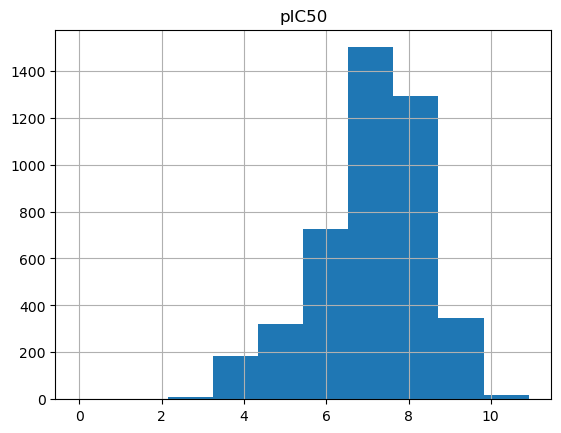

In [42]:
# Draw compound data
output_df.hist(column="pIC50")

In the next steps, we add a column for RDKit molecule objects to our DataFrame and look at the structures of the molecules with the highest pIC50 values.

In [43]:
# Add molecule column
PandasTools.AddMoleculeColumnToFrame(output_df, smilesCol="smiles")

In [44]:
# Sort molecules by pIC50
output_df.sort_values(by="pIC50", ascending=False, inplace=True)

# Reset index
output_df.reset_index(drop=True, inplace=True)

In [45]:
# Show the three most active molecules, i.e. molecules with the highest pIC50 values.
output_df.drop("smiles", axis=1).head(3)

,molecule_chembl_id,IC50,units,pIC50,ROMol
0,CHEMBL237119,0.012,nM,10.920819,<rdkit.Chem.rdchem.Mol object at 0x173d06a50>
1,CHEMBL4113723,0.050,nM,10.301030,<rdkit.Chem.rdchem.Mol object at 0x173d3b510>
2,CHEMBL237336,0.064,nM,10.193820,<rdkit.Chem.rdchem.Mol object at 0x173d06ac0>


In [46]:
# Prepare saving the dataset: Drop the ROMol column
output_df = output_df.drop("ROMol", axis=1)
print(f"DataFrame shape: {output_df.shape}")

DataFrame shape: (4401, 5)


In [48]:
output_df.to_csv("output_data.csv", index=False)